#### Toy examples under the different metric loss on MNIST dataset(10 class with 2D features). 

* Softmax loss : traditional multi classification loss [(softmax+cross entropy loss)](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=cross%20entropy#torch.nn.CrossEntropyLoss)
* Sphereface loss : [SphereFace: Deep Hypersphere Embedding for Face Recognition](https://arxiv.org/pdf/1704.08063.pdf)
* Cosface loss : [CosFace: Large Margin Cosine Loss for Deep Face Recognition](https://arxiv.org/pdf/1801.09414.pdf)
* Arcface loss : [ArcFace: Additive Angular Margin Loss for Deep Face Recognition](https://arxiv.org/pdf/1801.07698.pdf)

In [17]:
import os 
import numpy as np
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from metric import *
from utils import *
import matplotlib.pyplot as plt

In [18]:
def plot_curve(train,test,epoch, type):
    plt.figure(facecolor='white')
    plt.plot(train,label='training data')
    plt.plot(test,label='testing data')
    if type == 'accuracy':
        plt.ylabel('accuracy')
        plt.title('Accuracy curve')
    elif type == 'loss':
        plt.ylabel('loss')
        plt.title('Learning curve')
    
    plt.xlabel('epoch')
    plt.legend(loc = 'best')
    plt.grid()
    plt.xticks(list(range(0,epoch+1,10)))
    plt.show()

def visualize(features, labels,METRIC):
    features = features.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

    colors = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    
    fig = plt.figure(figsize=(5, 5), dpi=100)

    
    fig.clf()
    for i in range(10):
        plt.plot(features[labels == i, 0], features[labels == i, 1], ".", c=colors[i], label=i)
    plt.legend(loc="upper right") 
    plt.title('{} of visualization'.format(METRIC))
    plt.grid()
    plt.show()
def visualize_cos(features, labels,METRIC,metric):
    weight = metric.state_dict()['weight']
    weight = weight / weight.norm(2, 1).unsqueeze(1).repeat(1, 2)
    weight = weight.cpu().detach().numpy()
    
    features = features / features.norm(2, 1).unsqueeze(1).repeat(1, 2)
    features = features.cpu().detach().numpy()
    
    labels = labels.cpu().detach().numpy()

    colors = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    
    fig = plt.figure(figsize=(5, 5), dpi=100)

    fig.clf()
    for i in range(10):
        plt.plot(features[labels == i, 0], features[labels == i, 1], ".", c=colors[i], label=i)
        plt.plot([0,weight[i][0]],[0,weight[i][1]],linewidth=2,color=colors[i])
    plt.legend(loc="upper right") 
    plt.title('{} of visualization in arc space'.format(METRIC))
    plt.grid()
    plt.show()

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 28*28*1 -> 28*28*32
            nn.BatchNorm2d(32), 
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),  # 28*28*32 -> 28*28*32
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 14*14*32
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  # 14*14*64
            nn.BatchNorm2d(64), 
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),  # 14*14*64
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 7*7*16
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # 7*7*64
            nn.BatchNorm2d(128), 
            nn.ReLU(),
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),  # 7*7*128
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 3*3*128
        )
        self.layer7 = nn.Sequential(
            nn.Linear(3 * 3 * 128, 512),
            nn.Linear(512, 128),
            nn.Linear(128, 2, bias=False),
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(x.size(0), -1)  
        feature = self.layer7(x)

        return feature

In [20]:
BATCH_SIZE = 200
LEARNING_RATE = 1e-3
EPOCHS = 50
dataTransform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
train_dataset = datasets.MNIST(root='./MNIST', train=True, transform=dataTransform, download=True)
test_dataset = datasets.MNIST(root='./MNIST', train=False, transform=dataTransform, download=True)
train_loader = MultiEpochsDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)
test_loader = MultiEpochsDataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=2)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

metric_dict = {'softmax':Softmax, 'sphereface':SphereFace, 'cosface':CosFace, 'arcface':ArcFace}

In [21]:
def main(metric,model,criterion,optimizer,scheduler):
    train_lc, test_lc, train_ac, test_ac = [], [], [], []

    epoch_tqdm = tqdm(range(EPOCHS))
    for epoch in epoch_tqdm:
        
        train(train_loader,model,metric,criterion,optimizer,device,scheduler)
        
        acc, loss,features_list, labels_list = test(train_loader,model,metric,criterion,device)
        train_lc.append(loss)
        train_ac.append(acc)
        train_features = torch.cat(features_list, dim=0)
        train_labels = torch.cat(labels_list, dim=0)
        
        acc, loss,features_list, labels_list = test(test_loader,model,metric,criterion,device)
        test_lc.append(loss)
        test_ac.append(acc)
        test_features = torch.cat(features_list, dim=0)
        test_labels = torch.cat(labels_list, dim=0)
    plot_curve(train_lc,test_lc,epoch,'loss')
    return train_features,train_labels

### Softmax loss

100%|██████████| 50/50 [06:34<00:00,  7.89s/it]


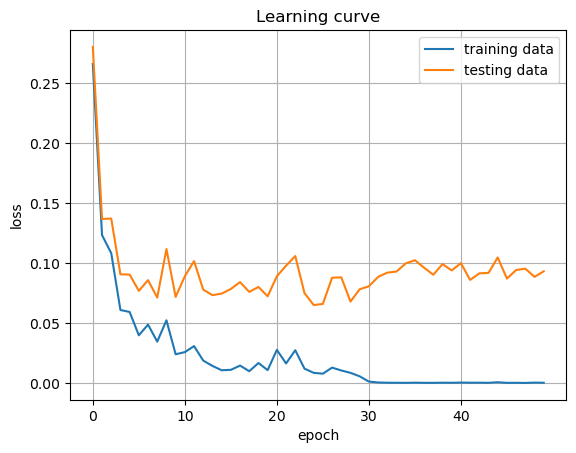

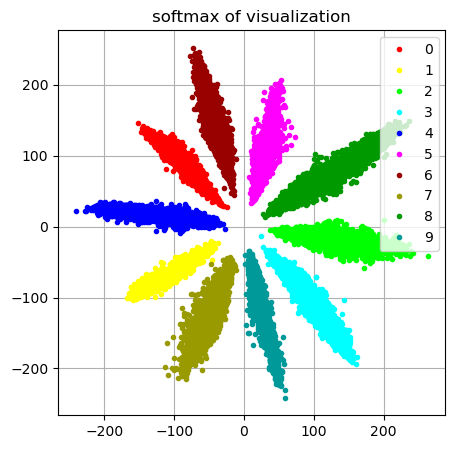

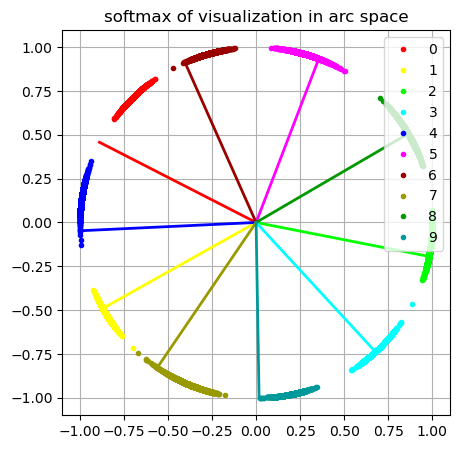

In [22]:
METRIC = 'softmax'
model = Net().to(device)
softmax_metric = metric_dict[METRIC](num_classes=10, embedding_size=2).to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': softmax_metric.parameters()}],
                                  betas=[0.9,0.99], lr=LEARNING_RATE, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[30],gamma=0.1)

train_features, train_labels = main(softmax_metric,model,criterion,optimizer,scheduler)
visualize(train_features, train_labels, METRIC)
visualize_cos(train_features, train_labels, METRIC,softmax_metric)

### Sphereface loss

100%|██████████| 50/50 [06:57<00:00,  8.36s/it]


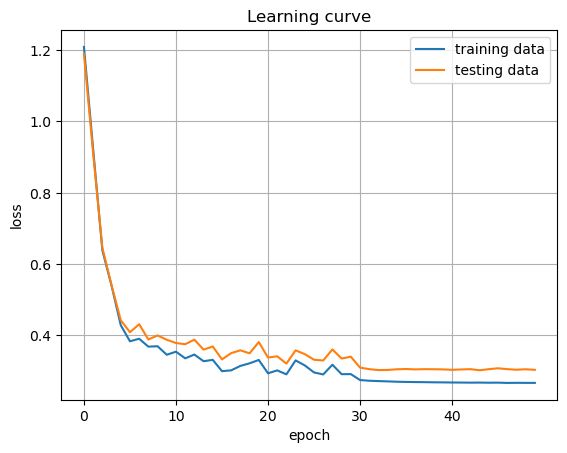

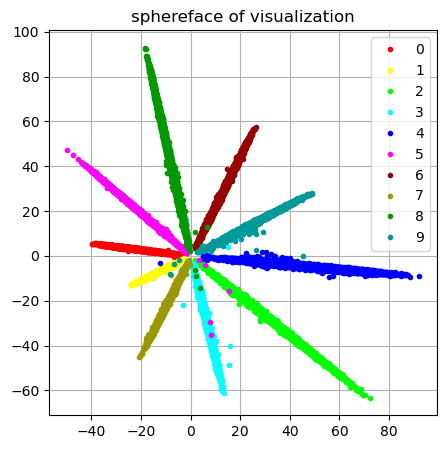

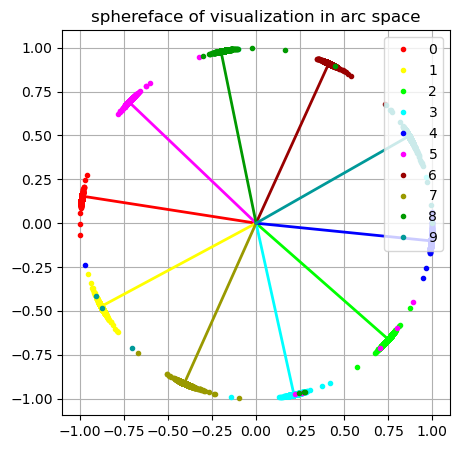

In [23]:
METRIC = 'sphereface'
model = Net().to(device)
sphereface_metric = metric_dict[METRIC](num_classes=10, embedding_size=2,margin_m=1.35, margin_s=10.0).to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': sphereface_metric.parameters()}],
                                  betas=[0.9,0.99], lr=LEARNING_RATE, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[30],gamma=0.1)

train_features, train_labels = main(sphereface_metric,model,criterion,optimizer,scheduler)
visualize(train_features, train_labels,METRIC)
visualize_cos(train_features, train_labels,METRIC,sphereface_metric)

### Cosface loss

100%|██████████| 50/50 [06:47<00:00,  8.14s/it]


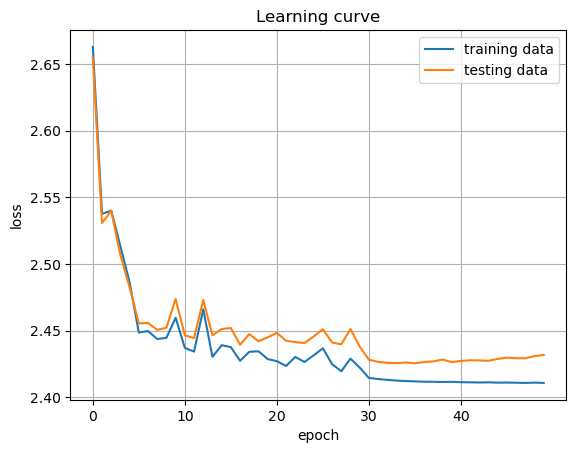

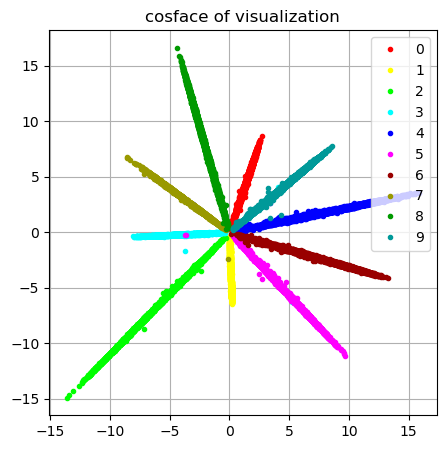

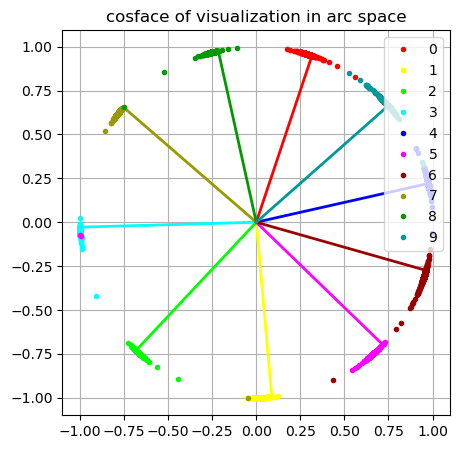

In [24]:
METRIC = 'cosface' 
model = Net().to(device)
cosface_metric = metric_dict[METRIC](num_classes=10, embedding_size=2,margin_m=0.5, margin_s=5.0).to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': cosface_metric.parameters()}],
                                  betas=[0.9,0.99], lr=LEARNING_RATE, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[30],gamma=0.1)

train_features, train_labels = main(cosface_metric,model,criterion,optimizer,scheduler)
visualize(train_features, train_labels,METRIC)
visualize_cos(train_features, train_labels,METRIC,cosface_metric)

### Arcface loss

100%|██████████| 50/50 [06:40<00:00,  8.01s/it]


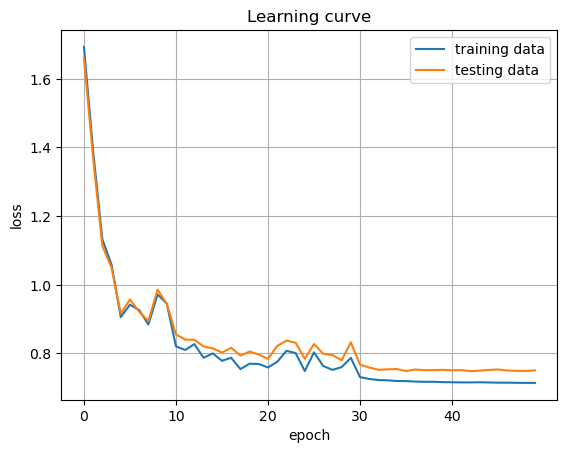

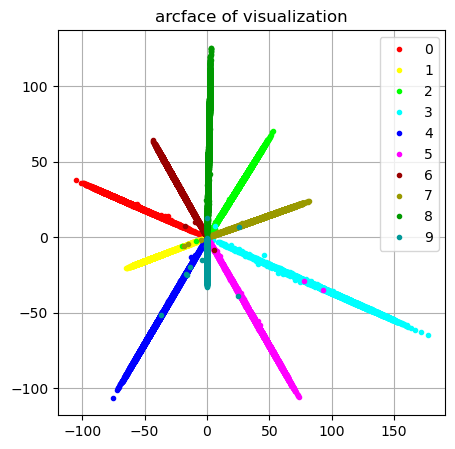

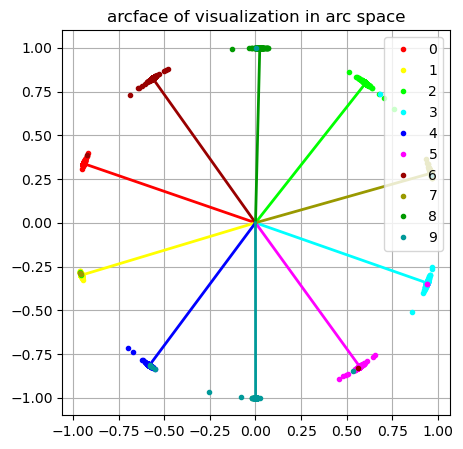

In [25]:
METRIC = 'arcface'
model = Net().to(device)
arcface_metric = metric_dict[METRIC](num_classes=10, embedding_size=2, margin_m=0.5, margin_s=10.0).to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': arcface_metric.parameters()}],
                                  betas=[0.9,0.99], lr=LEARNING_RATE, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[30],gamma=0.1)

train_features, train_labels = main(arcface_metric,model,criterion,optimizer,scheduler)
visualize(train_features, train_labels, METRIC)
visualize_cos(train_features, train_labels, METRIC,arcface_metric)